In [96]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import glob
from sklearn.model_selection import train_test_split
from sklearn import metrics
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
sns.set(style='white', context='notebook', rc={'figure.figsize':(10,8)})
import matplotlib.pyplot as plt
import visualkeras

In [97]:
image_list = []
genres = []
for filename in glob.glob('../images_original/*/*.png'): #assuming png
    im = np.array(Image.open(filename).convert('L'))/255 - 0.5
    genre = filename.split('/')[2]
    
    genres.append(genre)
    image_list.append(im)

In [98]:
unique_genres = list(np.unique(genres))
unique_genres

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [99]:
def map_genre_to_onehot(genre_str):
    '''
    Genre str: String containing genre name
    Returns: one hot encoding of genre string given list of classes
    '''
    ohe = np.zeros(shape=(10,))
    genre_idx = unique_genres.index(genre_str)
    ohe[genre_idx] = 1
    return ohe

In [100]:
def map_genre_to_number(genre_str):
    genre_idx = unique_genres.index(genre_str)
    return genre_idx

In [101]:
genres = pd.Series(genres)
genres_nums = genres.map(map_genre_to_number).values

In [102]:
y = to_categorical(genres_nums)
y.shape

(999, 10)

In [103]:
genres = pd.Series(genres)
genres_onehot = genres.map(map_genre_to_onehot)

In [104]:
X = np.asarray(image_list).reshape(999,288,432,1)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [197]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

In [198]:
#create model
model = tf.keras.Sequential()
#add model layers
model.add(Conv2D(10, kernel_size=4, activation='relu', input_shape=(288,432,1)))
model.add(MaxPooling2D(pool_size=4))
model.add(Conv2D(10, kernel_size=4, activation='relu'))
model.add(MaxPooling2D(pool_size=4))
model.add(Conv2D(10, kernel_size=4, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

opt = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 285, 429, 10)      170       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 71, 107, 10)       0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 68, 104, 10)       1610      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 17, 26, 10)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 14, 23, 10)        1610      
_________________________________________________________________
flatten_19 (Flatten)         (None, 3220)              0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 3220)            

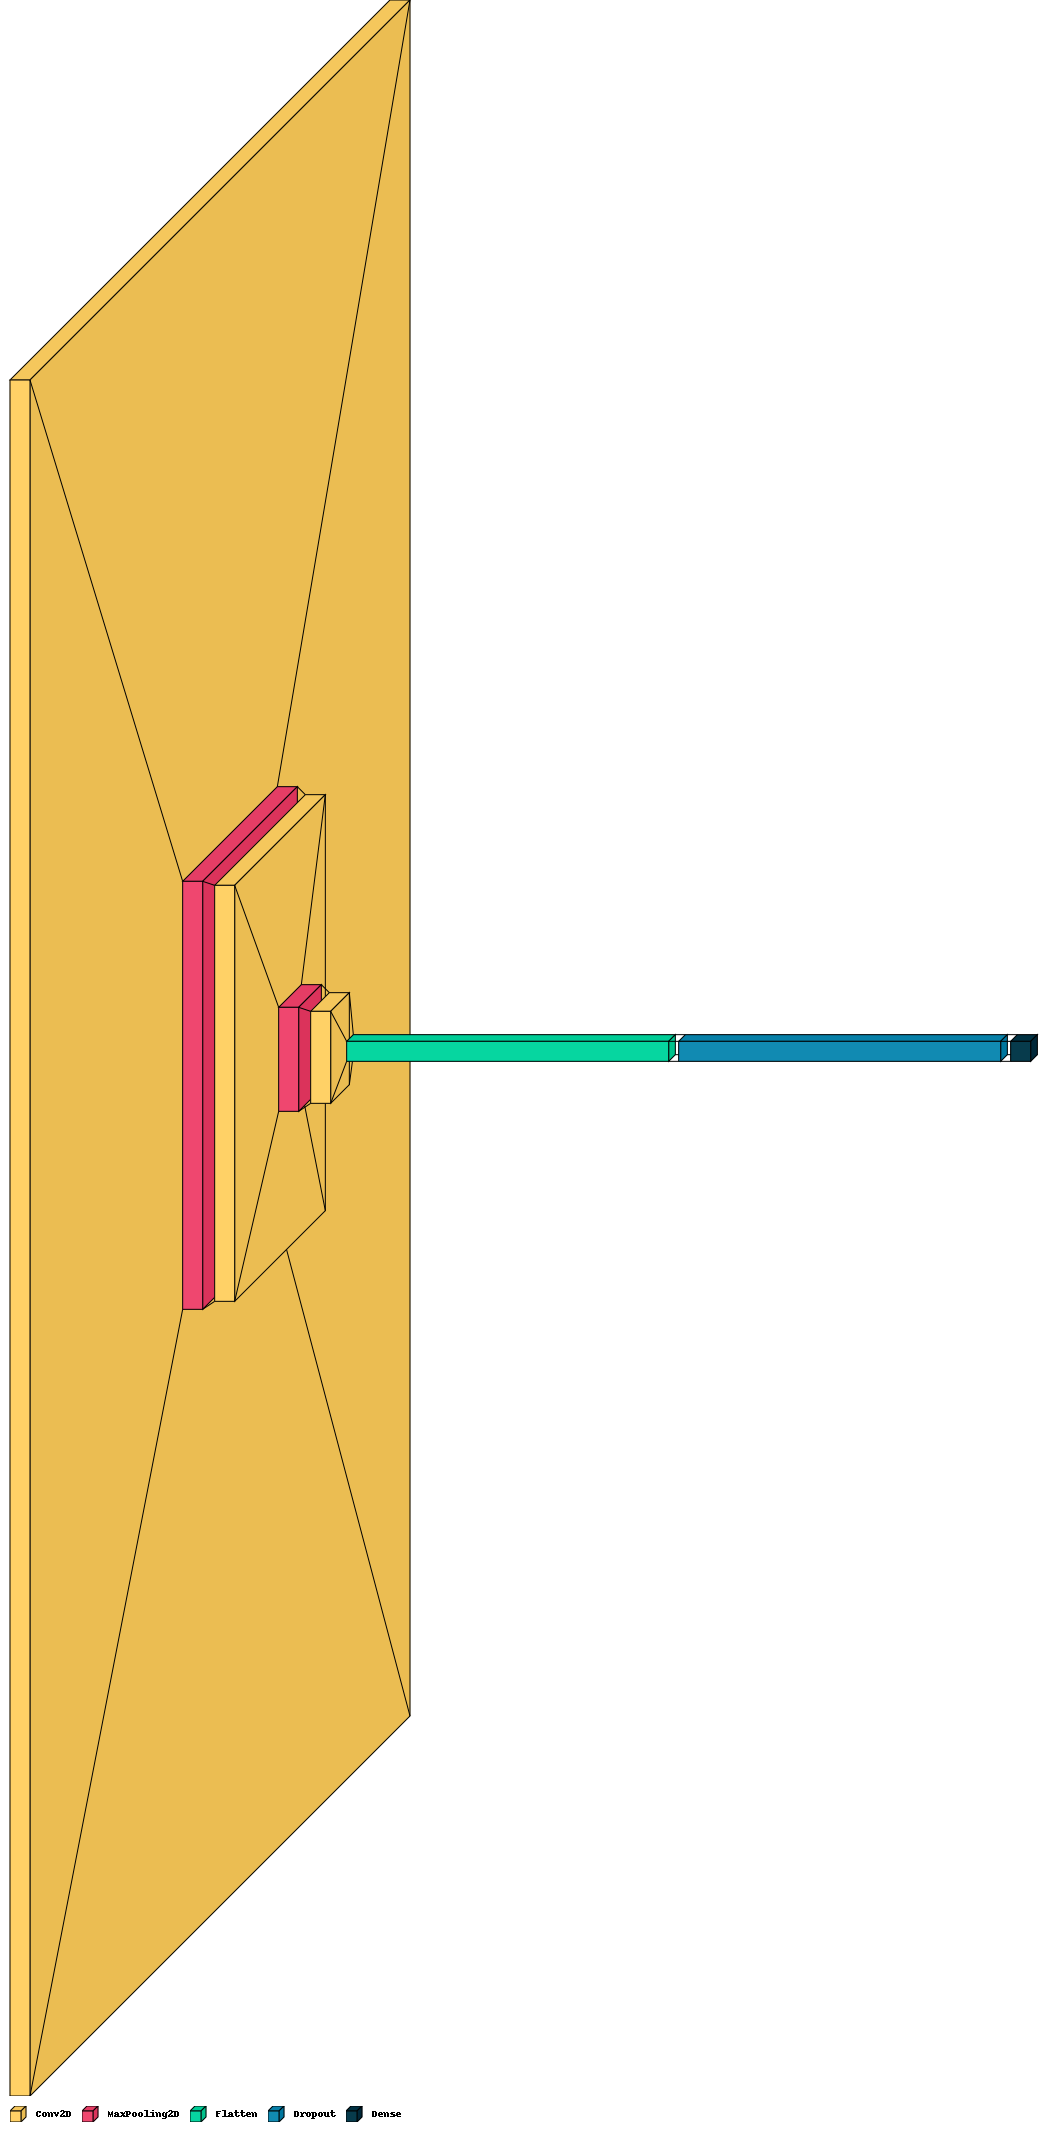

In [199]:
visualkeras.layered_view(model, legend = True)

In [218]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=8, verbose=1, callbacks=[early_stopping])

Train on 799 samples, validate on 200 samples
Epoch 1/150
799/799 [==============================] - 29s 36ms/sample - loss: 2.2587 - accuracy: 0.1539 - val_loss: 2.1471 - val_accuracy: 0.2200
Epoch 2/150
799/799 [==============================] - 28s 35ms/sample - loss: 1.8419 - accuracy: 0.3429 - val_loss: 1.9012 - val_accuracy: 0.2750
Epoch 3/150
799/799 [==============================] - 28s 35ms/sample - loss: 1.5994 - accuracy: 0.4193 - val_loss: 1.7044 - val_accuracy: 0.3900
Epoch 4/150
799/799 [==============================] - 28s 35ms/sample - loss: 1.5009 - accuracy: 0.4793 - val_loss: 1.5701 - val_accuracy: 0.4350
Epoch 5/150
799/799 [==============================] - 28s 35ms/sample - loss: 1.3100 - accuracy: 0.5582 - val_loss: 1.6012 - val_accuracy: 0.4050
Epoch 6/150
799/799 [==============================] - 28s 36ms/sample - loss: 1.1495 - accuracy: 0.6158 - val_loss: 1.5041 - val_accuracy: 0.4450
Epoch 7/150
799/799 [==============================] - 28s 36ms/sample -

In [219]:
preds = model.predict(X_test)

matrix = metrics.confusion_matrix(y_test.argmax(axis = -1), preds.argmax(axis = -1), normalize = 'true')
matrix_non_normal = metrics.confusion_matrix(y_test.argmax(axis = -1), preds.argmax(axis = -1))

       label  accuracy
1  classical  0.888889
5       jazz  0.800000
6      metal  0.695652
8     reggae  0.647059
3      disco  0.521739
0      blues  0.500000
4     hiphop  0.500000
2    country  0.388889
7        pop  0.333333
9       rock  0.305556


<BarContainer object of 10 artists>

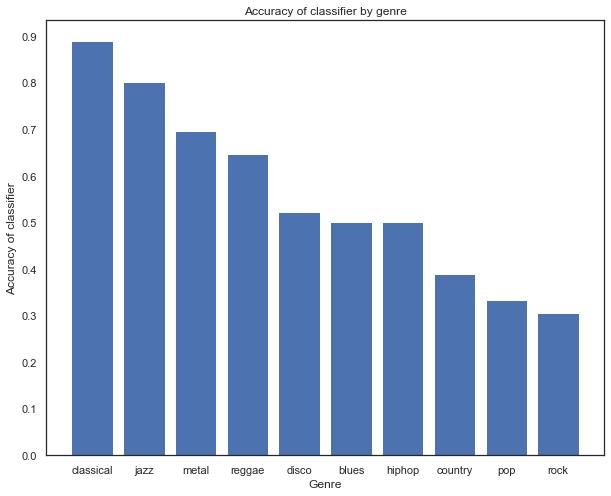

In [220]:
cm = matrix_non_normal
diag_entries = [cm[i,i] for i in range(len(cm))]
class_accuracy = diag_entries / np.sum(cm, axis=0)

acc_df = pd.DataFrame({'label':unique_genres, 'accuracy':class_accuracy})
acc_df = acc_df.sort_values(by='accuracy', ascending=False)
print(acc_df)

plt.xlabel('Genre')
plt.ylabel('Accuracy of classifier')

plt.yticks(np.arange(0,1.05,step=0.1))

plt.title('Accuracy of classifier by genre')
plt.bar(acc_df['label'], acc_df['accuracy'])

In [221]:
metrics.ConfusionMatrixDisplay(matrix)

<AxesSubplot:>

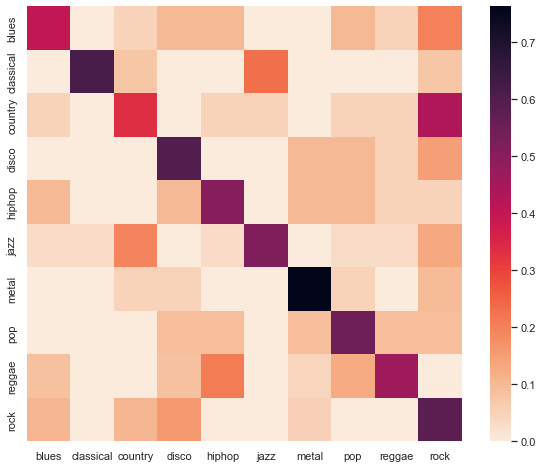

In [222]:
sns.heatmap(matrix, yticklabels = unique_genres, xticklabels = unique_genres, cmap = 'rocket_r', square = True)

In [223]:
print(metrics.classification_report(y_test.argmax(axis = -1), preds.argmax(axis = -1), target_names = unique_genres))

              precision    recall  f1-score   support

       blues       0.50      0.40      0.44        20
   classical       0.89      0.62      0.73        13
     country       0.39      0.33      0.36        21
       disco       0.52      0.60      0.56        20
      hiphop       0.50      0.50      0.50        20
        jazz       0.80      0.52      0.63        31
       metal       0.70      0.76      0.73        21
         pop       0.33      0.55      0.41        11
      reggae       0.65      0.46      0.54        24
        rock       0.31      0.58      0.40        19

    accuracy                           0.53       200
   macro avg       0.56      0.53      0.53       200
weighted avg       0.57      0.53      0.53       200



In [243]:
# plot feature map of first conv layer for given image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims


model_small = Model(inputs=model.inputs, outputs=model.layers[4].output)
model_small.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55_input (InputLayer) [(None, 288, 432, 1)]     0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 285, 429, 10)      170       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 71, 107, 10)       0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 68, 104, 10)       1610      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 17, 26, 10)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 14, 23, 10)        1610      
Total params: 3,390
Trainable params: 3,390
Non-trainable params: 0
________________________________________________________

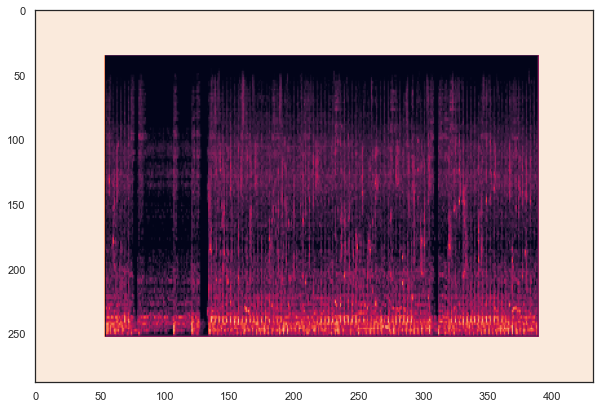

In [246]:
img = X_test[5]
plt.imshow(img)
img = expand_dims(img, axis=0)

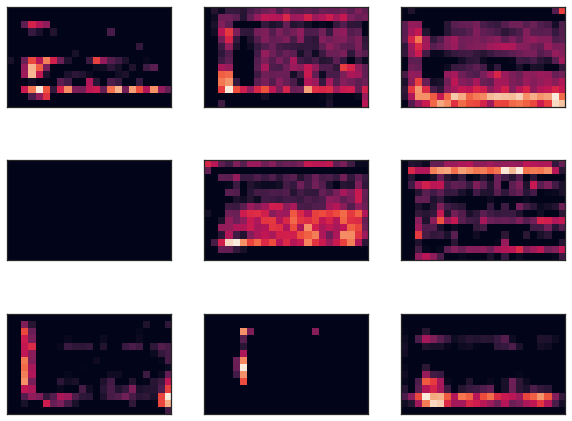

In [247]:
# get feature map for first hidden layer
feature_maps = model_small.predict(img)
# plot all 64 maps in an 8x8 squares
square = 3

ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :, :, ix-1])
		ix += 1
# show the figure
plt.show()

In [171]:
unique_genres[y_test[6].argmax(axis = -1)]

'classical'